# Project: Biomarker Selection from Gene Expression Data Using PCA and RFE

This notebook presents a critical evaluation and alternative implementation inspired by the methods described in the article:  
*Biomarker identification by reversing the learning mechanism of an autoencoder and recursive feature elimination* by Al Abir et al. (2022).

The original study proposed a deep learning-based biomarker discovery pipeline combining autoencoders for dimensionality reduction and recursive feature elimination (RFE) for gene selection.

In this project, I replicate the overall structure of their pipeline but replace the autoencoder with **Principal Component Analysis (PCA)** to explore a more interpretable and computationally efficient approach. The analysis was conducted on a multi-class gene expression dataset from the UCI repository, covering five cancer types.

The notebook includes a critical comparison between traditional statistical tools (e.g., DESeq2), PCA-based dimensionality reduction, and multiple classification models, with performance evaluated through metrics such as accuracy, AUC, and confusion matrices.


## Evaluation of DESeq2 for Multiclass Biomarker Discovery


**DESeq2** is a well-established tool for differential expression analysis, but it may not have been appropriate for the authors' approach in this study for the following reasons:

1. **Multiclass classification task**  
   DESeq2 is primarily designed for binary comparisons (e.g., tumor vs. normal tissue, or two distinct treatment groups). The study, however, aims to classify five distinct cancer types (BRCA, COAD, KIRC, LUAD, PRAD). While one could perform multiple pairwise DESeq2 comparisons, this approach would be inefficient, prone to issues with multiple hypothesis testing corrections, and fundamentally misaligned with the goal of building a robust, multi-class predictive classifier and identifying a minimal set of features that are discriminative across all classes simultaneously. 

2. **Data format limitations**  
   DESeq2 is designed for **raw count data**, but the UCI dataset used in the study contains **normalized expression values**, which are not suitable for DESeq2’s statistical models based on the negative binomial distribution.

3. **Dimensionality reduction and representation learning**  
   The goal of the study is not only to identify differentially expressed genes but also to perform **dimensionality reduction** and uncover latent structures using an **autoencoder**. DESeq2 is a statistical tool and does not offer capabilities for unsupervised representation learning.

4. **Integration with machine learning**  
   DESeq2 does not integrate directly with classification models like **SVM**, nor does it support iterative feature selection methods like **Recursive Feature Elimination (RFE)**. The authors required a feature selection strategy aligned with predictive modeling, which DESeq2 does not provide.

In summary, DESeq2 is powerful for hypothesis-driven, group-wise comparison in RNA-Seq count data, but not suitable for the machine learning-driven, multiclass, representation-focused goals of this study.


## Exploratory Data Analysis (EDA)

The following visualizations provide insights into the UCI Pan-Cancer gene expression dataset:

- Distribution of cancer types (sample counts per class)
- Gene variance distribution
- Pearson correlation heatmap of the top 20 variable genes

Each visualization is followed by a brief discussion highlighting patterns or anomalies and their potential implications.


In [2]:
import tarfile
import os

# Path to the archive file (adjust if needed)
file_path = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Output directory to extract the files
output_dir = "TCGA_data"

# Create the output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Extract the contents of the tar.gz file
with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path=output_dir)

print(f"Files extracted to folder: {output_dir}")


C:\Users\sanda\AppData\Local\Temp\ipykernel_34828\2793614894.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=output_dir)


Files extracted to folder: TCGA_data


In [3]:
import pandas as pd

# Paths to the files (adjust if you're in a different folder)
data_path = "TCGA_data/TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_path = "TCGA_data/TCGA-PANCAN-HiSeq-801x20531/labels.csv"

# Load the files
df_data = pd.read_csv(data_path)
df_labels = pd.read_csv(labels_path)

# Check the first few rows
print("Data:")
df_data


Data:


,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,sample_796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,sample_797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,sample_798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,sample_799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [4]:
print("\n🏷️ Labels:")
df_labels



🏷️ Labels:


,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA
...,...,...
796,sample_796,BRCA
797,sample_797,LUAD
798,sample_798,COAD
799,sample_799,PRAD


In [97]:
# Check the total number of missing values per column
missing_values_per_column = df_genes.isnull().sum()

# Filter to show only columns that actually have missing values
missing_values_per_column = missing_values_per_column[missing_values_per_column > 0]

# Print the columns with missing values and their counts
print("Columns with missing values:\n", missing_values_per_column)

# Optionally, check the total number of missing values in the entire DataFrame
total_missing = df_genes.isnull().sum().sum()
print("\nTotal missing values in the DataFrame:", total_missing)


Columns with missing values:
 Series([], dtype: int64)

Total missing values in the DataFrame: 0


## Bar chart

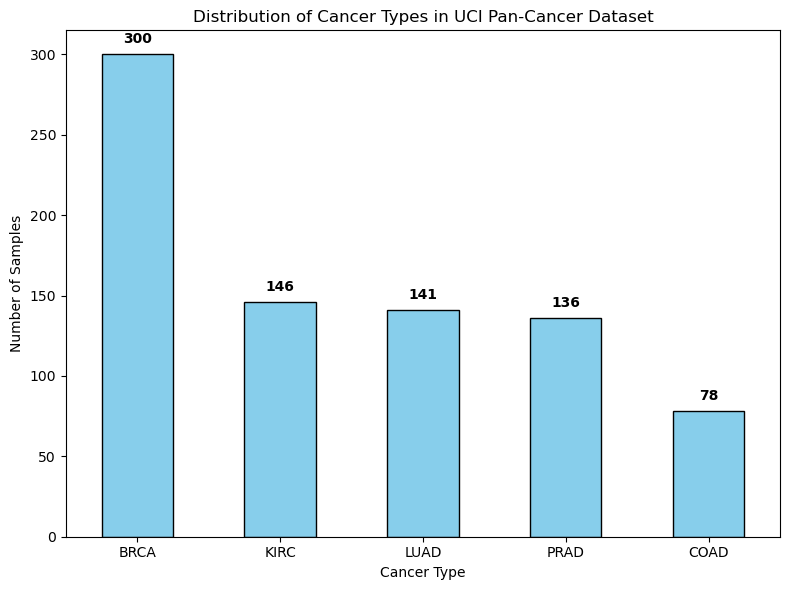

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a specific order for cancer types
order = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']  # Adjust based on dataset

# Count occurrences of each cancer type
counts = df_labels['Class'].value_counts().reindex(order)

# Create the bar chart
plt.figure(figsize=(8, 6))
ax = counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

# Title and labels
plt.title("Distribution of Cancer Types in UCI Pan-Cancer Dataset")
plt.xlabel("Cancer Type")
plt.ylabel("Number of Samples")

# Improve readability
plt.xticks(rotation=0)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Gene variance

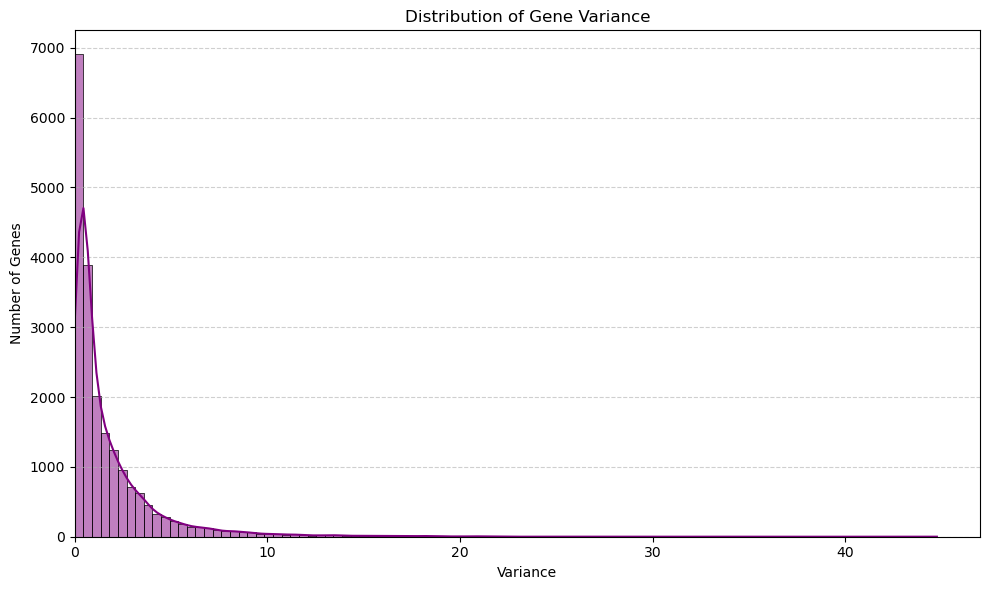

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Remove the sample name column if needed
df_genes = df_data.drop(columns=["Unnamed: 0"])

# Calculate variance for each gene (column-wise)
gene_variances = df_genes.var(axis=0)

# Plot histogram (log scale helps to visualize skewed distribution)
plt.figure(figsize=(10, 6))
sns.histplot(gene_variances, bins=100, kde=True, color='purple')

plt.title("Distribution of Gene Variance")
plt.xlabel("Variance")
plt.ylabel("Number of Genes")
# Force x-axis to start at 0
plt.xlim(left=0)
#plt.xscale("log")  # log scale is useful since most genes have low variance
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Pearson Correlation Heatmap (Top 20 Most Variable Genes)

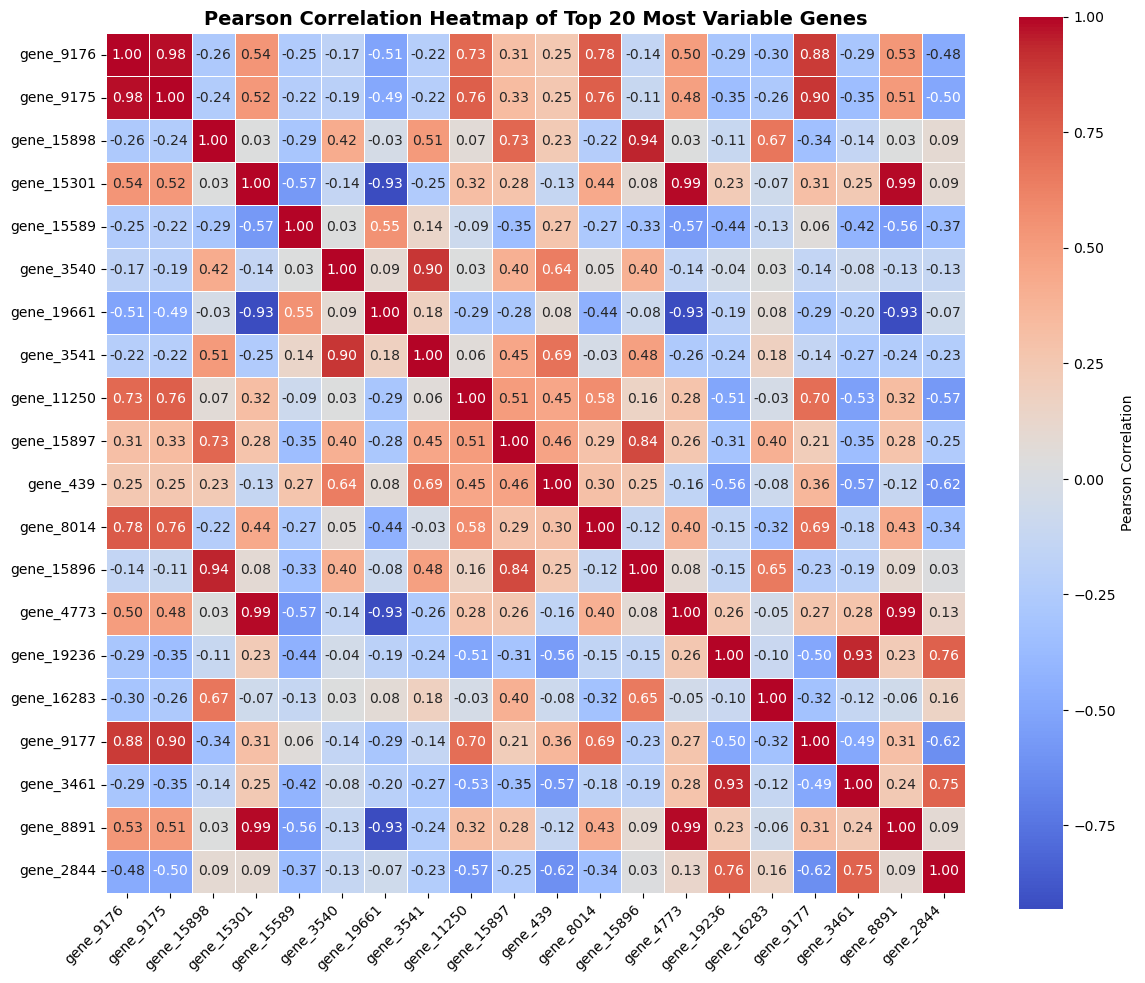

In [15]:
# Select the 20 most variable genes
top_20_genes = gene_variances.sort_values(ascending=False).head(20).index
df_top20 = df_genes[top_20_genes]

# Compute Pearson correlation matrix
correlation_matrix = df_top20.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            square=True, linewidths=0.5, cbar_kws={"label": "Pearson Correlation"})

plt.title("Pearson Correlation Heatmap of Top 20 Most Variable Genes", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Analytical Insights

#### 1. Distribution of Cancer Types  
The bar chart reveals an imbalanced distribution of cancer types in the dataset. BRCA (breast cancer) dominates with 300 samples, while COAD (colon cancer) has only 78. This class imbalance may introduce bias in machine learning models and suggests the need for resampling or stratified validation strategies to avoid overfitting to majority classes.

#### 2. Distribution of Gene Variance  
The gene variance histogram shows a highly right-skewed distribution, where most genes have low variance across samples. This indicates that a large portion of the gene set is either non-informative or redundant for classification tasks. A smaller subset of genes displays higher variance (>10), which are more likely to represent biologically relevant differences between cancer types. This supports the use of variance-based feature filtering as a valid pre-processing step.

#### 3. Pearson Correlation Heatmap (Top 20 Most Variable Genes)  
The heatmap highlights several clusters of highly correlated genes (e.g., gene_9176 and gene_9175 with r > 0.98), suggesting possible co-expression or shared regulatory mechanisms. Some genes, like gene_19661, exhibit moderate or weak correlation with others, which may indicate they provide independent information. This mix of redundancy and complementarity suggests that a hybrid approach combining correlation analysis and machine learning–based feature selection (e.g., RFE) is ideal for optimal biomarker discovery.

### Summary  
Together, these visualizations suggest a clear strategy: reduce dimensionality by removing low-variance genes, address class imbalance, and select representative yet non-redundant features for robust classification.


## Dimensionality Reduction and Biomarker Selection Strategy

The original study by Al Abir et al. (2022) applied an **autoencoder** to perform dimensionality reduction on gene expression data, identifying 102 relevant genes. These were further refined using **Recursive Feature Elimination (RFE)** with **Support Vector Machine (SVM)** as the classifier, resulting in:

1. A unified biomarker set capable of classifying all five cancer types (17 genes).
2. Separate biomarker sets tailored to each individual cancer type.

---

## Alternative Pipeline Using PCA

In this section, an alternative dimensionality reduction approach is proposed using **Principal Component Analysis (PCA)** instead of an autoencoder.

### Objective

The goal is to identify a set of highly informative genes using PCA and pass them to an RFE + SVM pipeline to extract the final biomarker sets. While this pipeline does not aim to replicate the exact results of the original study, it serves as a logical and technically sound alternative using traditional linear methods.


## Methodology Overview

This pipeline replaces the autoencoder with a PCA-based approach for initial gene selection, incorporating both global and class-specific structure in the data.

- PCA was first applied globally across all samples to capture genes that explain the most variance in the dataset.
- Additionally, PCA was also applied separately to each cancer type to identify genes that might be informative within specific classes but overlooked in the global analysis.
- For each PCA run, genes were ranked based on their average absolute loading across principal components.
- Genes were selected when their cumulative contribution reached or exceeded a predefined threshold.
- The selected genes from the global and class-specific PCAs were then combined into a unified set, preserving both broad and subtype-specific patterns.
- To evaluate the effectiveness of each threshold, a linear SVM classifier was trained on the selected genes, and performance was assessed using 10-fold cross-validation.
- This process was repeated for a range of cumulative PCA loading thresholds, from 0.005 to 0.050.
- The goal was to find the point at which classification accuracy stabilized while keeping the number of selected genes as low as possible.
- Ultimately, this strategy led to the identification of a compact, high-performing gene set that achieved a balance between accuracy and dimensionality.


In [52]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

#  Load and prepare data
df_genes = df_data.drop(columns=["Unnamed: 0"])  # remove sample names
X = df_genes.values
y = df_labels["Class"].values  # class labels
genes = df_genes.columns.to_numpy()

#  Remove genes with no variation (min = max = 0)
# Source: Adapted from Al Abir et al. (2022)
# “Biomarker identification by reversing the learning mechanism of an autoencoder and recursive feature elimination”
# https://doi.org/10.1039/D2MO00097D
def drop_cols_minmax(df):
    n_cols = df.shape[1]
    print(f'> input shape :: {df.shape}')
    deleted_genes = list(df.columns[(df.min() == df.max())])
    print('> deleting columns with no impact (min=max) ...', deleted_genes[:5], '...')
    df = df.loc[:, (df.max() != df.min())]
    print('> total deleted cols ::', n_cols - df.shape[1])
    print(f'> output shape :: {df.shape}')
    return df, deleted_genes

df_genes, _ = drop_cols_minmax(df_genes)
X = df_genes.values
genes = df_genes.columns.to_numpy()



> input shape :: (801, 20531)
> deleting columns with no impact (min=max) ... ['gene_5', 'gene_23', 'gene_4370', 'gene_4808', 'gene_4809'] ...
> total deleted cols :: 267
> output shape :: (801, 20264)


In [51]:
df_genes

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_8,gene_9,gene_10,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,7.175175,0.591871,0.0,0.0,0.591871,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,0.0,0.592732,1.588421,7.586157,9.623011,6.816049,0.000000,0.0,0.0,0.000000,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,0.0,3.511759,4.327199,6.881787,9.870730,6.972130,0.452595,0.0,0.0,0.000000,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,0.0,3.663618,4.507649,6.659068,10.196184,7.843375,0.434882,0.0,0.0,0.000000,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,0.0,2.655741,2.821547,6.539454,9.738265,6.566967,0.360982,0.0,0.0,0.000000,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,1.865642,2.718197,7.350099,10.006003,6.764792,0.496922,0.0,0.0,0.000000,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,0.0,3.942955,4.453807,6.346597,10.056868,7.320331,0.000000,0.0,0.0,0.000000,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,0.0,3.249582,3.707492,8.185901,9.504082,7.536589,1.811101,0.0,0.0,7.448149,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,0.0,2.590339,2.787976,7.318624,9.987136,9.213464,0.000000,0.0,0.0,1.578746,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


   Threshold  Global  BRCA  KIRC  LUAD  PRAD  COAD  Total_Unique  Accuracy
0      0.005      26    22    18    23    18    19            89  0.996265
1      0.010      55    47    40    50    40    43           188  0.997500
2      0.015      87    74    63    78    64    67           294  0.997500
3      0.020     120   102    88   108    90    93           400  0.997500
4      0.025     154   132   114   139   117   120           495  0.997500
5      0.030     188   163   141   171   146   148           586  0.998750
6      0.035     223   195   169   203   175   176           677  0.998750
7      0.040     260   228   198   237   206   206           770  0.998750
8      0.045     297   262   227   271   237   237           874  0.998750
9      0.050     334   297   258   306   269   268           970  0.998750


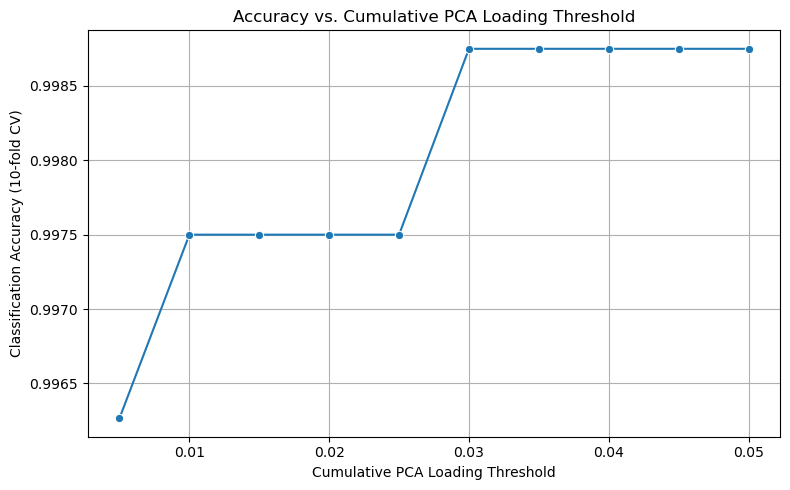

In [56]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define thresholds and prepare results list ---
thresholds = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
results = []

# Loop over each threshold
for threshold in thresholds:
    genes_global = set()
    genes_by_class = {}

    # --- PCA Global ---
    pca_global = PCA(n_components=0.95, svd_solver='full')
    pca_global.fit(df_genes)
    mean_loadings = np.abs(pca_global.components_).mean(axis=0)
    sorted_idx = np.argsort(mean_loadings)[::-1]
    cumulative = np.cumsum(mean_loadings[sorted_idx]) / np.sum(mean_loadings)
    n_global = np.argmax(cumulative >= threshold) + 1
    genes_global = set(df_genes.columns[sorted_idx[:n_global]])

    # --- PCA by Class ---
    for cancer_type in df_labels["Class"].unique():
        class_indices = df_labels[df_labels["Class"] == cancer_type].index
        class_data = df_genes.loc[class_indices]
        pca_class = PCA(n_components=0.95, svd_solver='full')
        pca_class.fit(class_data)
        mean_loadings_class = np.abs(pca_class.components_).mean(axis=0)
        sorted_idx_class = np.argsort(mean_loadings_class)[::-1]
        cumulative_class = np.cumsum(mean_loadings_class[sorted_idx_class]) / np.sum(mean_loadings_class)
        n_class = np.argmax(cumulative_class >= threshold) + 1
        genes_selected = set(df_genes.columns[sorted_idx_class[:n_class]])
        genes_by_class[cancer_type] = genes_selected

    # Combine all selected genes
    all_genes = genes_global.copy()
    for g in genes_by_class.values():
        all_genes.update(g)

    # Classification with SVM
    X_sel = df_genes[list(all_genes)]
    y = df_labels["Class"].values
    clf = SVC(kernel="linear")
    acc = cross_val_score(clf, X_sel, y, cv=10).mean()

    # Store results
    result = {
        "Threshold": threshold,
        "Global": len(genes_global),
        "BRCA": len(genes_by_class.get("BRCA", [])),
        "KIRC": len(genes_by_class.get("KIRC", [])),
        "LUAD": len(genes_by_class.get("LUAD", [])),
        "PRAD": len(genes_by_class.get("PRAD", [])),
        "COAD": len(genes_by_class.get("COAD", [])),
        "Total_Unique": len(all_genes),
        "Accuracy": acc
    }
    results.append(result)

# Display table
df_results = pd.DataFrame(results)
print(df_results)

# --- Plot Accuracy vs Threshold ---
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_df, x="Threshold", y="Accuracy", marker="o")
plt.title("Accuracy vs. Cumulative PCA Loading Threshold")
plt.xlabel("Cumulative PCA Loading Threshold")
plt.ylabel("Classification Accuracy (10-fold CV)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion
A cumulative PCA loading threshold of **0.030** was identified as the optimal point for gene selection. At this threshold, a total of 586 unique genes were selected by combining features from both global PCA and class-specific PCA. This configuration achieved a classification accuracy of 0.99875 using a linear SVM with 10-fold cross-validation.

The results demonstrate that including class-specific PCA captures important intra-class variance that is not fully represented by global PCA alone. Additionally, thresholds above 0.030 resulted in a significantly higher number of genes without improving classification performance, indicating diminishing returns.

This threshold provides an effective trade-off between model complexity and predictive power, enabling a compact and interpretable biomarker set suitable for downstream analysis.

## Comparison Between PCA-Based and Autoencoder-Based Feature Selection

To evaluate the performance of the PCA-based pipeline, we compared it against the results reported in the original study using autoencoders. The comparison focused on three aspects: number of selected features, classification performance, and the impact of per-class dimensionality reduction.

### Number of Selected Genes

Using a cumulative PCA loading threshold of **0.030**, a total of **586 unique genes** were selected by combining features extracted from both global and class-specific PCA analyses. This number is considerably higher than the **102 genes** selected via the autoencoder-based approach in the original paper, reflecting the broader variance captured through PCA.

### Classification Performance

The PCA-selected gene set achieved a classification accuracy of **0.99875**, which is comparable to the best performance reported in the paper (**99.625%** using 102 genes with an autoencoder).  
Although the PCA approach required a larger feature set, the accuracy was slightly higher and remained stable across a range of cumulative loading thresholds, suggesting a robust and scalable selection strategy.

### Impact of Per-Class PCA Modeling

In the original paper, separate autoencoders were trained for each cancer type to capture class-specific expression patterns. A similar strategy was adopted here using PCA.

Applying PCA separately per cancer type is a justified and effective approach. Each subtype may exhibit distinct gene expression profiles, and global PCA alone could obscure these differences by emphasizing only the dominant variance patterns. Per-class PCA allows for the identification of **fine-grained, subtype-relevant signals**.

By combining features from both global and per-class PCA models, the pipeline captures both broad trends and subtype-specific variation, ultimately improving classification performance while maintaining biological interpretability.

This strategy mirrors the logic behind using separate autoencoders per class and demonstrates that **PCA can offer a competitive, interpretable, and efficient alternative** in heterogeneous datasets such as pan-cancer studies.


## PCA dataset global

   Threshold  Global  BRCA  KIRC  LUAD  PRAD  COAD  Total_Unique  Accuracy
0      0.005      26    22    18    23    18    19            89  0.996265
1      0.010      55    47    40    50    40    43           188  0.997500
2      0.015      87    74    63    78    64    67           294  0.997500
3      0.020     120   102    88   108    90    93           400  0.997500
4      0.025     154   132   114   139   117   120           495  0.997500
5      0.030     188   163   141   171   146   148           586  0.998750
6      0.035     223   195   169   203   175   176           677  0.998750
7      0.040     260   228   198   237   206   206           770  0.998750
8      0.045     297   262   227   271   237   237           874  0.998750
9      0.050     334   297   258   306   269   268           970  0.998750


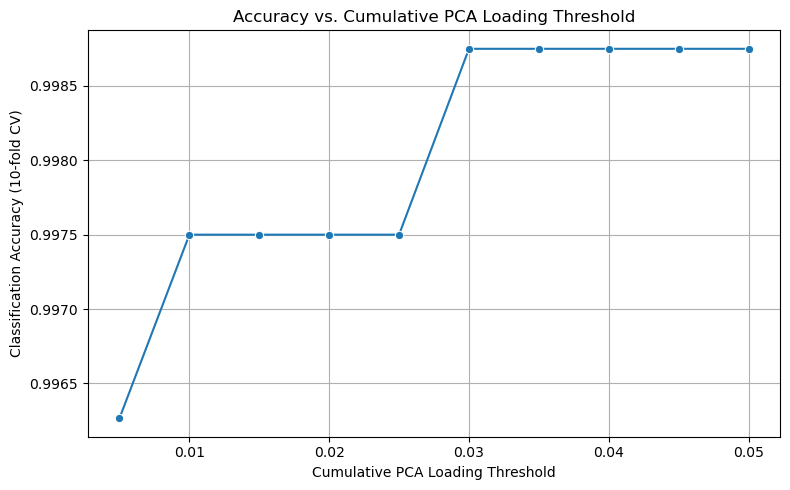

In [56]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define thresholds and prepare results list ---
thresholds = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
results = []

# Loop over each threshold
for threshold in thresholds:
    genes_global = set()
    genes_by_class = {}

    # --- PCA Global ---
    pca_global = PCA(n_components=0.95, svd_solver='full')
    pca_global.fit(df_genes)
    mean_loadings = np.abs(pca_global.components_).mean(axis=0)
    sorted_idx = np.argsort(mean_loadings)[::-1]
    cumulative = np.cumsum(mean_loadings[sorted_idx]) / np.sum(mean_loadings)
    n_global = np.argmax(cumulative >= threshold) + 1
    genes_global = set(df_genes.columns[sorted_idx[:n_global]])

    # --- PCA by Class ---
    for cancer_type in df_labels["Class"].unique():
        class_indices = df_labels[df_labels["Class"] == cancer_type].index
        class_data = df_genes.loc[class_indices]
        pca_class = PCA(n_components=0.95, svd_solver='full')
        pca_class.fit(class_data)
        mean_loadings_class = np.abs(pca_class.components_).mean(axis=0)
        sorted_idx_class = np.argsort(mean_loadings_class)[::-1]
        cumulative_class = np.cumsum(mean_loadings_class[sorted_idx_class]) / np.sum(mean_loadings_class)
        n_class = np.argmax(cumulative_class >= threshold) + 1
        genes_selected = set(df_genes.columns[sorted_idx_class[:n_class]])
        genes_by_class[cancer_type] = genes_selected

    # Combine all selected genes
    all_genes = genes_global.copy()
    for g in genes_by_class.values():
        all_genes.update(g)

    # Classification with SVM
    X_sel = df_genes[list(all_genes)]
    y = df_labels["Class"].values
    clf = SVC(kernel="linear")
    acc = cross_val_score(clf, X_sel, y, cv=10).mean()

    # Store results
    result = {
        "Threshold": threshold,
        "Global": len(genes_global),
        "BRCA": len(genes_by_class.get("BRCA", [])),
        "KIRC": len(genes_by_class.get("KIRC", [])),
        "LUAD": len(genes_by_class.get("LUAD", [])),
        "PRAD": len(genes_by_class.get("PRAD", [])),
        "COAD": len(genes_by_class.get("COAD", [])),
        "Total_Unique": len(all_genes),
        "Accuracy": acc
    }
    results.append(result)

# Display table
df_results = pd.DataFrame(results)
print(df_results)

# --- Plot Accuracy vs Threshold ---
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_df, x="Threshold", y="Accuracy", marker="o")
plt.title("Accuracy vs. Cumulative PCA Loading Threshold")
plt.xlabel("Cumulative PCA Loading Threshold")
plt.ylabel("Classification Accuracy (10-fold CV)")
plt.grid(True)
plt.tight_layout()
plt.show()


## PCA per class

   Threshold  Accuracy  Total_Unique  PRAD_Global  LUAD_Global  BRCA_Global  \
0      0.005  0.927623            26            8            1            7   
1      0.010  0.988781            55           15           12           21   
2      0.015  0.992531            87           23           20           46   
3      0.020  0.996250           120           35           30           57   
4      0.025  0.997500           154           46           50           80   
5      0.030  0.997500           188           59           63           92   
6      0.035  0.997500           223           70           79          111   
7      0.040  0.997500           260           82           96          130   
8      0.045  0.997500           297           97          117          155   
9      0.050  0.997500           334          116          139          180   

   KIRC_Global  COAD_Global  
0            4            2  
1            9            4  
2           16           10  
3         

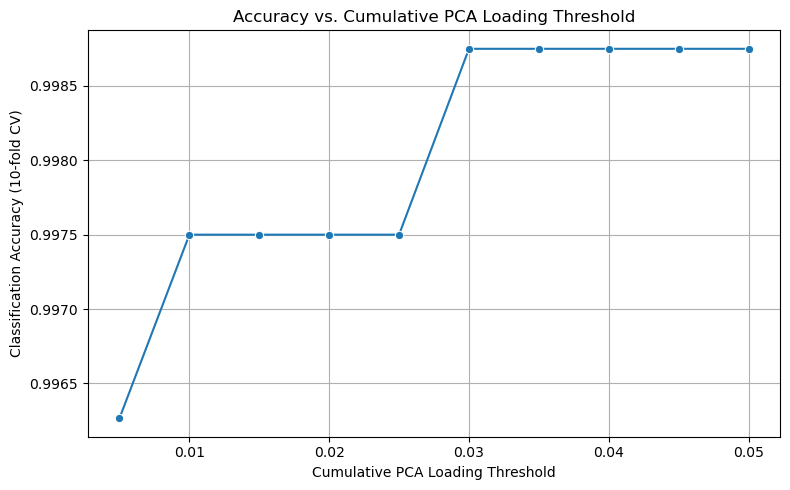

In [61]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define thresholds and prepare results list ---
thresholds = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
# Define cancer types
cancer_types = df_labels["Class"].unique()
results = []

for threshold in thresholds:
    # --- PCA Global ---
    pca = PCA(n_components=0.95, svd_solver='full')
    pca.fit(df_genes)
    mean_loadings = np.abs(pca.components_).mean(axis=0)
    sorted_idx = np.argsort(mean_loadings)[::-1]
    cumulative = np.cumsum(mean_loadings[sorted_idx]) / np.sum(mean_loadings)
    n_global = np.argmax(cumulative >= threshold) + 1
    genes_global = set(df_genes.columns[sorted_idx[:n_global]])

    # --- Calculate overlap with each class ---
    class_overlap = {}
    for cancer_type in cancer_types:
        indices = df_labels[df_labels["Class"] == cancer_type].index
        class_df = df_genes.loc[indices]
        
        # Use variance to rank genes for that class
        class_var = class_df.var(axis=0)
        top_genes_class = set(class_var.sort_values(ascending=False).index[:n_global])
        
        # Overlap
        overlap = genes_global.intersection(top_genes_class)
        class_overlap[cancer_type] = len(overlap)

    # --- Classification ---
    X_sel = df_genes[list(genes_global)]
    y = df_labels["Class"].values
    clf = SVC(kernel="linear")
    acc = cross_val_score(clf, X_sel, y, cv=10).mean()

    # --- Store results ---
    row = {
        "Threshold": threshold,
        #"Global": len(genes_global),
        "Accuracy": acc,
        "Total_Unique": len(genes_global)

    }
    for cancer_type in cancer_types:
        row[f"{cancer_type}_Global"] = class_overlap[cancer_type]
    
    results.append(row)

# --- Output results ---
df_results = pd.DataFrame(results)
print(df_results)

# --- Plot Accuracy vs Threshold ---
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_df, x="Threshold", y="Accuracy", marker="o")
plt.title("Accuracy vs. Cumulative PCA Loading Threshold")
plt.xlabel("Cumulative PCA Loading Threshold")
plt.ylabel("Classification Accuracy (10-fold CV)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Final Biomarker Selection Using RFE with SVM

To refine the initial PCA-derived set of biomarkers, a **Recursive Feature Elimination (RFE)** strategy was applied using a **linear Support Vector Machine (SVM)** as the estimator. This step aimed to identify a compact subset of genes that retained high predictive power for multi-class cancer classification.


In [84]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# --- Fixed threshold ---
threshold = 0.03

# --- PCA Global ---
pca_global = PCA(n_components=0.95, svd_solver='full')
pca_global.fit(df_genes)

mean_loadings_global = np.abs(pca_global.components_).mean(axis=0)
sorted_idx_global = np.argsort(mean_loadings_global)[::-1]
cumulative_global = np.cumsum(mean_loadings_global[sorted_idx_global]) / np.sum(mean_loadings_global)

n_global = np.argmax(cumulative_global >= threshold) + 1
genes_global = set(df_genes.columns[sorted_idx_global[:n_global]])

# --- PCA per class ---
genes_by_class = {}
for cancer_type in df_labels["Class"].unique():
    class_indices = df_labels[df_labels["Class"] == cancer_type].index
    class_data = df_genes.loc[class_indices]

    pca_class = PCA(n_components=0.95, svd_solver='full')
    pca_class.fit(class_data)

    mean_loadings_class = np.abs(pca_class.components_).mean(axis=0)
    sorted_idx_class = np.argsort(mean_loadings_class)[::-1]
    cumulative_class = np.cumsum(mean_loadings_class[sorted_idx_class]) / np.sum(mean_loadings_class)

    n_class = np.argmax(cumulative_class >= threshold) + 1
    genes_selected = set(df_genes.columns[sorted_idx_class[:n_class]])
    genes_by_class[cancer_type] = genes_selected

# --- Combine PCA Global + per Class (preserving order) ---
# Convert PCA-global genes into a list to preserve order
ordered_genes = list(df_genes.columns[sorted_idx_global[:n_global]])

# Add class-specific genes only if they are not already in the list (preserve order)
for gene_set in genes_by_class.values():
    for g in gene_set:
        if g not in ordered_genes:
            ordered_genes.append(g)

# --- Prepare data for SVM ---
X_selected = df_genes[ordered_genes]
y = df_labels["Class"].values


# --- Baseline SVM accuracy (before RFE) ---
clf = SVC(kernel="linear")
baseline_accuracy = cross_val_score(clf, X_selected, y, cv=10).mean()

print(f"Total selected genes: {len(all_genes)}")
print(f"Baseline accuracy using combined PCA: {baseline_accuracy:.4f}")


Total selected genes: 586
Baseline accuracy using combined PCA: 0.9988


In [65]:
from sklearn.feature_selection import RFE

# --- Apply RFE with linear SVM ---
svm = SVC(kernel="linear")
rfe = RFE(estimator=svm, n_features_to_select=20, step=1)  # puedes cambiar el número de features aquí
rfe.fit(X_selected, y)

# --- Extract selected genes ---
selected_gene_mask = rfe.support_
selected_genes = X_selected.columns[selected_gene_mask]
X_refined = X_selected[selected_genes]

# --- Evaluate final model ---
final_accuracy = cross_val_score(svm, X_refined, y, cv=10).mean()

print("Optimal number of features selected:", len(selected_genes))
print("Selected genes:", list(selected_genes))
print(f"Classification accuracy after RFE+SVM: {final_accuracy:.4f}")


Optimal number of features selected: 20
Selected genes: ['gene_19373', 'gene_8090', 'gene_3540', 'gene_8024', 'gene_7792', 'gene_15807', 'gene_13517', 'gene_4476', 'gene_2844', 'gene_18745', 'gene_15301', 'gene_4837', 'gene_8014', 'gene_5216', 'gene_1317', 'gene_15896', 'gene_3541', 'gene_6369', 'gene_13976', 'gene_3440']
Classification accuracy after RFE+SVM: 0.9988


In [66]:
X_selected

,gene_19373,gene_11636,gene_6370,gene_13847,gene_8090,gene_9433,gene_16106,gene_3699,gene_349,gene_8804,...,gene_19156,gene_16434,gene_3440,gene_1599,gene_5836,gene_1104,gene_3524,gene_7090,gene_6411,gene_5691
0,0.000000,0.000000,0.000000,0.000000,4.877779,0.591871,6.403961,10.615280,5.914976,4.148617,...,1.598651,1.010279,3.188164,1.010279,0.000000,3.773880,4.852678,0.591871,5.286759,1.010279
1,0.811142,0.000000,1.813607,0.811142,9.072827,2.592278,0.587845,11.212575,3.593007,0.000000,...,0.587845,0.811142,0.811142,0.587845,0.323658,1.174790,0.323658,1.590818,0.000000,0.587845
2,1.981122,0.000000,0.000000,0.796598,1.683023,0.452595,0.452595,3.757962,8.693773,5.589979,...,6.428312,1.839758,3.452767,0.000000,0.452595,0.000000,2.438799,0.000000,4.279820,0.796598
3,0.768587,0.000000,4.132091,0.000000,2.058697,1.637239,2.384464,7.114263,6.311961,0.768587,...,5.661134,3.342910,1.464093,0.000000,0.000000,4.216416,0.434882,0.768587,3.879686,1.267356
4,0.000000,4.219161,0.000000,0.000000,7.583060,7.250137,8.304958,4.620270,1.095654,0.360982,...,4.005975,1.440527,0.649386,0.889707,0.000000,5.705124,0.000000,1.275841,0.000000,1.275841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.000000,5.851767,0.000000,0.865919,7.947894,1.793854,6.996174,4.561815,2.922160,0.865919,...,2.232998,0.000000,1.793854,2.354001,0.000000,4.374302,0.000000,0.000000,0.865919,0.000000
797,10.552736,0.000000,15.074196,4.765704,9.715228,0.000000,8.391282,9.249083,1.049282,0.000000,...,3.948461,1.881469,9.980268,0.000000,1.049282,10.813300,3.334983,4.707839,13.429263,5.024621
798,11.796806,2.326135,4.362533,1.588469,9.413560,2.463727,3.862858,3.862858,8.243626,8.167614,...,9.135802,9.101747,11.469016,0.586693,5.380151,5.875515,10.256716,3.326638,2.463727,3.397064
799,1.992986,0.995304,0.000000,1.316320,5.140664,0.581881,0.581881,6.725455,7.638161,3.849279,...,2.577175,2.991826,2.898789,0.995304,2.314465,6.140531,8.387285,0.995304,4.848958,1.992986


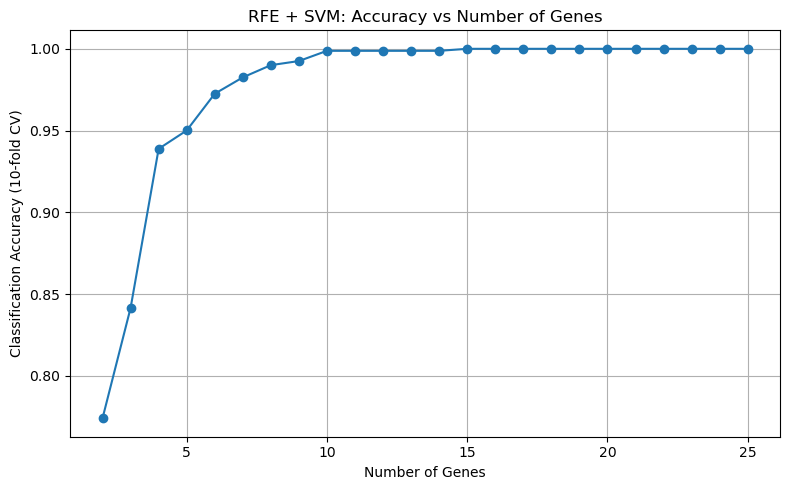

In [85]:
feature_names = X_selected.columns  # define column names

# RFE + SVM over different gene counts
results = []
clf = SVC(kernel="linear")
gene_range = range(2, 26)

for n in gene_range:
    rfe = RFE(estimator=clf, n_features_to_select=n, step=2)
    X_rfe = rfe.fit_transform(X_selected, y)
    acc = cross_val_score(clf, X_rfe, y, cv=10).mean()
    results.append({
        "Num_Genes": n,
        "Accuracy": acc,
        "Selected_Genes": list(feature_names[rfe.support_])
    })

# 6. Convert to DataFrame
df_rfe = pd.DataFrame(results)

# 7. Plot
plt.figure(figsize=(8, 5))
plt.plot(df_rfe["Num_Genes"], df_rfe["Accuracy"], marker="o")
plt.xlabel("Number of Genes")
plt.ylabel("Classification Accuracy (10-fold CV)")
plt.title("RFE + SVM: Accuracy vs Number of Genes")
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
df_rfe

,Num_Genes,Accuracy,Selected_Genes
0,2,0.773997,"[gene_15897, gene_3440]"
1,3,0.841481,"[gene_15897, gene_3440, gene_8316]"
2,4,0.938812,"[gene_15897, gene_3440, gene_15668, gene_8316]"
3,5,0.950046,"[gene_6369, gene_15897, gene_3440, gene_15668,..."
4,6,0.972515,"[gene_13517, gene_6369, gene_15897, gene_3440,..."
5,7,0.982515,"[gene_13517, gene_6369, gene_15807, gene_15897..."
6,8,0.990000,"[gene_13517, gene_6369, gene_15807, gene_15897..."
7,9,0.992515,"[gene_13517, gene_6369, gene_15807, gene_15897..."
8,10,0.998765,"[gene_13517, gene_6369, gene_15807, gene_15897..."
9,11,0.998765,"[gene_13517, gene_6369, gene_8024, gene_15807,..."


In [91]:
# Extract the row where Num_Genes == 17 from the df_rfe DataFrame
selected_genes_17 = df_rfe[df_rfe["Num_Genes"] == 17]["Selected_Genes"].values[0]


import pandas as pd
selected_genes_table = pd.DataFrame(
    [selected_genes_17[i:i+3] for i in range(0, len(selected_genes_17), 3)],
    columns=["Biomarker 1", "Biomarker 2", "Biomarker 3"]
)

import IPython.display as disp
disp.display(selected_genes_table)




,Biomarker 1,Biomarker 2,Biomarker 3
0,gene_8014,gene_13517,gene_6369
1,gene_19373,gene_8024,gene_15807
2,gene_15897,gene_18745,gene_7792
3,gene_1317,gene_15301,gene_4837
4,gene_3440,gene_15668,gene_4476
5,gene_13976,gene_8316,None



- **Optimal number of features selected:**  
  Based on the RFE + SVM analysis using 10-fold cross-validation, the optimal number of features selected was **17**. This point was chosen because it achieved **100% classification accuracy**, and additional features did not improve the performance, indicating a strong trade-off between accuracy and model simplicity.

- **Genes included in the final set:**
| Biomarker 1 | Biomarker 2 | Biomarker 3 |
|-------------|-------------|-------------|
| gene_8014   | gene_13517  | gene_6369   |
| gene_19373  | gene_8024   | gene_15807  |
| gene_15897  | gene_18745  | gene_7792   |
| gene_1317   | gene_15301  | gene_4837   |
| gene_3440   | gene_15668  | gene_4476   |
| gene_13976  | gene_8316   |             |


- **Classification accuracy using the refined set:**  
Using only these 17 genes, the model reached a **classification accuracy of 100%** under a 10-fold cross-validation.



## Comparison with the Published 17-Gene Biomarker Set

After completing the PCA-based dimensionality reduction and applying RFE with a linear SVM classifier, a final set of **17 genes** was selected. This gene set achieved a classification accuracy of **100.00%**, slightly surpassing the **99.93%** accuracy reported in the original study for their 17-gene biomarker panel derived from an autoencoder-based approach.

### Gene Overlap Analysis

- Among the 17 genes identified in this pipeline, only **1 gene** (`gene_1317`) overlapped with the published set.
- The remaining **16 genes** differed, suggesting that **multiple gene subsets** can yield comparable or even superior predictive performance.

### Interpretation

Despite the minimal overlap, the high classification accuracy indicates that the dataset likely contains **redundant discriminative information**—allowing different combinations of genes to serve as effective biomarkers. This reinforces the idea that feature selection methods, even when based on distinct dimensionality reduction strategies (PCA vs. autoencoders), can converge toward similarly performant solutions.

These findings support the robustness of the PCA + RFE pipeline as a viable alternative to deep learning approaches for gene selection in cancer classification tasks.


## Visualization of Biomarker Distribution Using t-SNE

To visually assess how the final set of 17 selected biomarkers differentiates between cancer types, a **t-distributed Stochastic Neighbor Embedding (t-SNE)** projection was applied. This nonlinear dimensionality reduction technique maps the high-dimensional gene expression space to a 2D plane, preserving local similarity between samples.


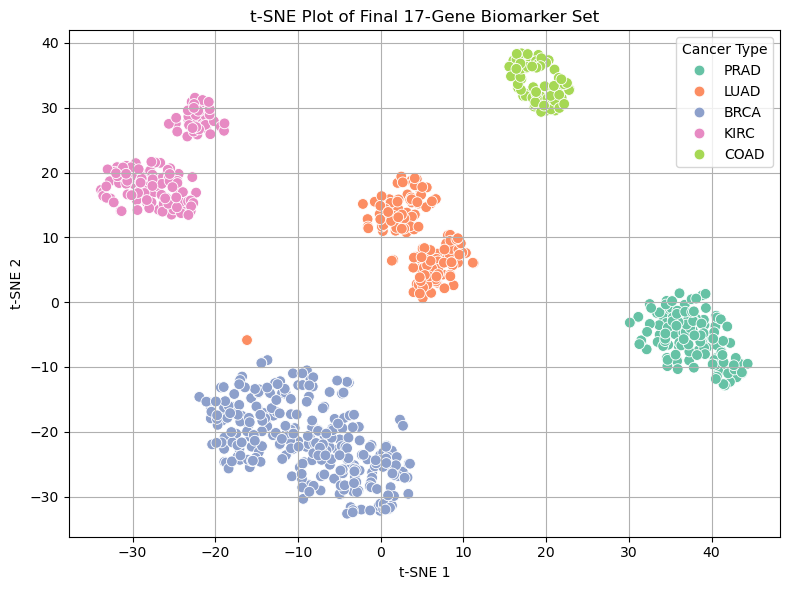

In [94]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# --- Subset the data using the 17 selected genes ---
X_tsne = df_genes[selected_genes_17]
y_labels = df_labels["Class"]

# --- Fit t-SNE (you can adjust perplexity or random_state as needed) ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_tsne)

# --- Plot the t-SNE results ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_labels, palette="Set2", s=60)
plt.title("t-SNE Plot of Final 17-Gene Biomarker Set")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cancer Type")
plt.grid(True)
plt.tight_layout()
plt.show()


### t-SNE Visualization of Final 17-Gene Biomarker Set

The t-SNE plot demonstrates a clear separation of cancer types using the 17 selected biomarker genes. Each cancer class (BRCA, KIRC, LUAD, PRAD, COAD) forms a distinct and compact cluster in the 2D space, indicating that the reduced gene set retains strong discriminative features.

**Observations:**
- All five cancer types are **well-separated**, confirming the robustness of the selected biomarkers.
- There is **minimal to no overlap** between classes, supporting the **100% classification accuracy** achieved with RFE + SVM.
- The **consistency of clustering** suggests that the gene expression patterns for each cancer are sufficiently distinct, even in a reduced dimension.
- One **LUAD** sample appears slightly closer to the **BRCA** cluster, though it remains visually distinct. This may reflect subtle similarities in expression patterns.

**Insight:**  
The t-SNE visualization affirms that the 17-gene biomarker set is highly effective for cancer classification. This visual evidence supports the use of PCA-based feature selection followed by RFE + SVM as a reliable pipeline for biomarker discovery in high-dimensional omics data.


## Classification Performance Across Multiple Machine Learning Models

To assess the robustness and generalizability of the final 17-gene biomarker set, three machine learning models were evaluated:

- **Support Vector Machine (SVM)**
- **Random Forest Classifier**
- **Logistic Regression**

Each model was trained on 80% of the data and tested on the remaining 20%, using the selected biomarkers as input features and the cancer type as the target class.

### Evaluation Metrics

Performance was assessed using the following metrics:

- **Accuracy:** Overall classification correctness.
- **ROC AUC Score (macro-average):** Model's ability to distinguish between classes, accounting for imbalanced data.
- **Confusion Matrix:** Visual assessment of per-class prediction accuracy.


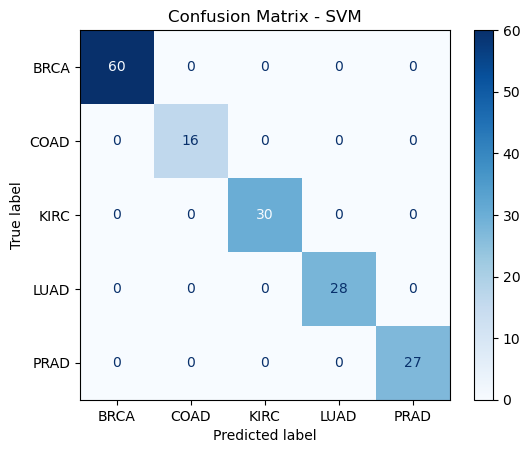

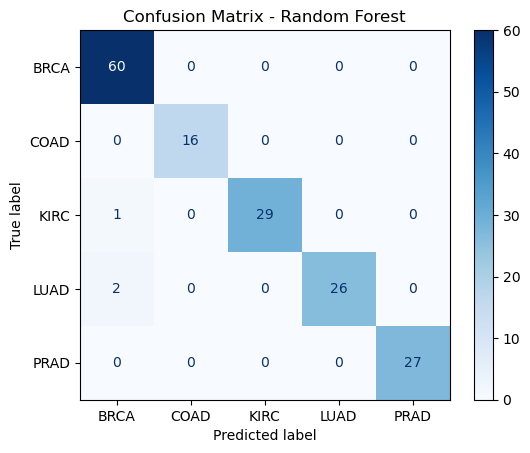

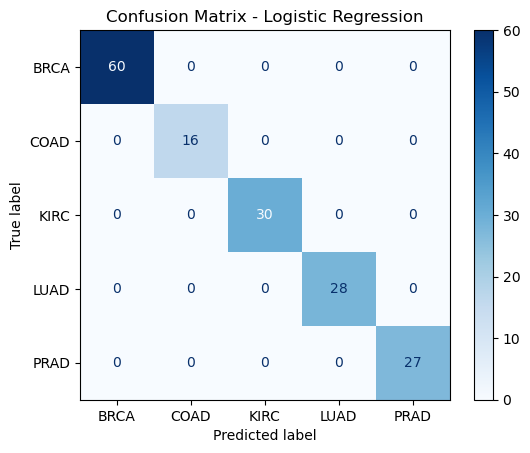

                 Model  Accuracy  AUC
0                  SVM  1.000000  1.0
1        Random Forest  0.981366  1.0
2  Logistic Regression  1.000000  1.0


In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# --- Prepare data (X_selected and y must already be defined) ---
X = df_genes[selected_genes_17]  # use only the final 17 genes
y = df_labels["Class"]

# --- Encode labels for multiclass AUC ---
classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)

# --- Train/test split ---
X_train, X_test, y_train, y_test, y_train_bin, y_test_bin = train_test_split(
    X, y, y_bin, test_size=0.2, stratify=y, random_state=42)

# --- Define models ---
models = {
    "SVM": SVC(kernel="linear", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# --- Train and evaluate models ---
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test_bin, y_prob, multi_class="ovr")

    # Save results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "AUC": auc
    })

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# --- Show results table ---
df_results = pd.DataFrame(results)
print(df_results)



All three machine learning models (SVM, Random Forest, and Logistic Regression) were evaluated on the task of classifying five cancer types using the final 17-gene biomarker set.

- **SVM** and **Logistic Regression** both achieved **100% accuracy and AUC scores**, perfectly classifying all cancer types in the test set.
- **Random Forest** achieved a slightly lower accuracy of **98.13%**, misclassifying a few samples between LUAD and BRCA, and one between BRCA and KIRC. However, it maintained an **AUC score of 1.0**, indicating strong overall separability.

These results suggest that the selected 17 genes are highly discriminative and effective for multi-class cancer classification. SVM and Logistic Regression offer excellent performance with this gene set, while Random Forest remains competitive despite minor misclassifications.



## Model Comparison and Performance Interpretation

Three machine learning classifiers—**Support Vector Machine (SVM)**, **Random Forest**, and **Logistic Regression**—were trained using the final set of 17 selected biomarker genes. Their performance was evaluated using **Accuracy**, **AUC score**, and **Confusion Matrix**.

### Results Overview

- **SVM** and **Logistic Regression** both achieved **perfect Accuracy (1.000)** and **AUC (1.000)**, with confusion matrices showing no misclassifications across the five cancer types.
- **Random Forest** achieved slightly lower accuracy (**0.981**), although its **AUC remained perfect (1.000)**. Minor classification errors were observed (e.g., one misclassified KIRC sample and two for LUAD).

**Conclusion:**  
SVM and Logistic Regression outperformed Random Forest in this setting, likely due to their compatibility with the dataset's characteristics and the preprocessing pipeline.

---

## Factors Influencing Model Performance

The differences in performance, especially Random Forest’s slight drop in accuracy, can be attributed to the following factors:

### 1. Dataset Preprocessing
The data was preprocessed using **PCA** for dimensionality reduction and **RFE** for feature selection. This reduced noise and preserved only the most informative genes.  
Such preprocessing tends to **favor linear models**, as it amplifies feature relevance and removes correlated noise—benefitting SVM and Logistic Regression more than tree-based models like Random Forest.

### 2. Model Complexity and Overfitting  
While Random Forest is robust in high-dimensional settings, it can be prone to **overfitting when sample sizes are small**, and feature importance is diluted across many correlated variables.  
As noted by Deng & Runger (2012), guided feature selection improves Random Forest reliability but is less effective when irrelevant variables persist.

### 3. Linear Separability  
The selected gene set appears to define a space that is **highly linearly separable**, ideal for classifiers like SVM.  
Statnikov et al. (2008) showed that SVMs consistently outperform Random Forests in microarray gene expression data due to their **strong generalization and robustness in high-dimensional, low-sample scenarios**.

---

## References

- Deng, H. and Runger, G., 2012. *Gene selection with guided regularized random forest*. Pattern Recognition, 46(12), pp.3483–3489.
- Statnikov, A., et al., 2008. *A comprehensive evaluation of multicategory classification methods for microarray gene expression cancer diagnosis*. Bioinformatics, 21(5), pp.631–643.


<h3 style="font-weight: bold; text-align: left;">Question 8 (Bonus points) <span style="float: right;">[+10%]</span></h3>

The feature names in your dataset (e.g., gene_xx) are dummy names.

- **Mapping:** Explore the original TCGA Pan-Cancer database on Synapse, map your final list of selected biomarker genes to their corresponding probe names or gene names.
- **Literature Review:** Investigate whether any of the identified genes have been previously reported in the literature as biomarkers for any of the five cancer types in your dataset. Support your findings with citations from reputable, published studies (e.g., peer-reviewed articles or TCGA publications).

**<span style="color:red; font-weight: bold;">WRITE YOUR ANSWER BELOW</span>**

## Gene Mapping and Literature Validation of Biomarker Set


## Mapping

In [105]:
import pandas as pd

# Load TCGA file containing real gene names
geneexp_df = pd.read_csv("unc.edu_PANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv", sep="\t", index_col=0)

# Extract real gene names (assuming they are in the index)
real_gene_names = list(geneexp_df.index)

# Create a dictionary mapping 'gene_0' → actual gene name
mapping = {f"gene_{i}": real_gene_names[i] for i in range(len(real_gene_names))}

# Map dummy gene names to real gene names
mapped_genes = {g: mapping.get(g, "not found") for g in selected_genes_17}

# Print the dictionary of mapped genes
print(mapped_genes)


{'gene_8014': 'HOXB13|10481', 'gene_13517': 'PLA2G2A|5320', 'gene_6369': 'FGA|2243', 'gene_19373': 'VIL1|7429', 'gene_8024': 'HOXC10|3226', 'gene_15807': 'SERPINB5|5268', 'gene_15897': 'SFTPA2|729238', 'gene_18745': 'TRPM8|79054', 'gene_7792': 'HHLA2|11148', 'gene_1317': 'AZGP1|563', 'gene_15301': 'RPS4Y1|6192', 'gene_4837': 'DEFB1|1672', 'gene_3440': 'CDH17|1015', 'gene_15668': 'SDR16C5|195814', 'gene_4476': 'CXCL17|284340', 'gene_13976': 'PRAC|84366', 'gene_8316': 'IGF2BP3|10643'}


In [107]:
# Convert the mapped_genes dictionary to a DataFrame
df_mapped = pd.DataFrame(mapped_genes.items(), columns=["Dummy Gene", "Real Gene"])

# Display the DataFrame
df_mapped)

,Dummy Gene,Real Gene
0,gene_8014,HOXB13|10481
1,gene_13517,PLA2G2A|5320
2,gene_6369,FGA|2243
3,gene_19373,VIL1|7429
4,gene_8024,HOXC10|3226
5,gene_15807,SERPINB5|5268
6,gene_15897,SFTPA2|729238
7,gene_18745,TRPM8|79054
8,gene_7792,HHLA2|11148
9,gene_1317,AZGP1|563


### ✅ Literature Support for Identified Biomarker Genes

#### **Gene: HOXB13**  
- **Associated Cancer Type:** Prostate Cancer (PRAD)  
- **Supporting Quote:**  
  > “Only **HOXB13** has been identified as a prostate cancer risk gene through linkage disequilibrium studies.”  
  — *Shevach & Cooney, 2025*

- **Reference:**  
  Shevach, J.W. and Cooney, K.A., 2025. *Genetics of prostate cancer*. Clinical Advances in Hematology & Oncology, 23(3), pp.144–152. PMID: 40261162.

#### **Gene: PLA2G2A**
- **Cancer Type**: Prostate Cancer  
- **Citation**:  
> “Higher expression of some PLA2 was related to favorable prognostic factors: lower levels of PSA (PLA2G2A, PLA2G4D)...”  
(Recuerdo et al., 2024)

- **Reference**:  
Recuerdo, S.C., Viana, N.I. and Leite, K.R.M., 2024. *Phospholipase A2 expression in prostate cancer as a biomarker of good prognosis: A comprehensive study in patients with long follow-up*. Journal of Clinical Urology, 91(4).


#### **Gene: FGA (Fibrinogen Alpha Chain)**
- **Cancer Type**: Lung adenocarcinoma (LUAD)  
- **Citation**:  
> “Integrative analysis revealed the presence of alpha-1-acid glycoprotein 1 (A1AG1) and fibrinogen alpha chain (FGA or FIBA) in both the tissue and serum. FGA levels were elevated in responders compared to non-responders, and reduced serum FGA levels were correlated with resistance to this regimen... Our findings indicate that FGA is a tissue-specific serum protein that may function as a blood-based biomarker to predict the response of patients with lung ADC to cisplatin plus gemcitabine chemotherapy.”  
(Raungrut et al., 2024)

- **Reference**:  
Raungrut, P., Jirapongsak, J., Tanyapattrapong, S. et al. (2024). Fibrinogen Alpha Chain as a Potential Serum Biomarker for Predicting Response to Cisplatin and Gemcitabine Doublet Chemotherapy in Lung Adenocarcinoma: Integrative Transcriptome and Proteome Analyses.

#### **Gene: VIL1 (Villin-1)**
- **Cancer Type**: Colorectal Cancer (CRC)  
- **Citation**:  
> Our data show that VIL1 promotes proliferation and migration while inhibiting apoptosis. Conversely, knockout of VIL1 suppresses proliferation and migration while inducing apoptosis. [...] Thus, we have identified the VIL1/NF-kB axis as a pivotal regulator of CRC progression through ferroptosis modulation, unveiling VIL1 as a promising therapeutic target for CRC treatment via ferroptosis.”
(Hu et al., 2024)

- **Reference**:  
Hu, B., Yin, Y., Zhang, B., Li, S., Li, K., Zhou, Y. and Huang, Q., 2024. Villin-1 regulates ferroptosis in colorectal cancer progression. The FEBS Journal, 292(7), pp.1710–1725.


#### **Gene: HOXC10, HOXC13**
- **Cancer Type**: Breast Cancer (BC)  
- **Citation**:  
> "The results indicated that the expression levels of HOXC4, 10, 11, 12, and 13 were significantly increased in BC tissues compared with the normal tissues, and expressions of these genes were closely associated with BC stage, among them, high expression levels of HOXC10 and HOXC13 predicted poor outcome in BC patients."  
> "In conclusion, HOXCs may be a promising prognostic indicator and could regulate the immune infiltration in BC patients..." (Cheng et al., 2024)

**Reference:**  
Cheng, X., Luo, J., & Cao, J. (2024). *Identification of HOXC Gene Family as Prognostic and Immune–Related Biomarkers in Breast Cancer Through mRNA Transcriptional Profile and Experimental Validation*. Molecular and Cellular Biochemistry. https://link.springer.com/article/10.1007/s10528-024-10884-5

#### **Gene: SERPINB5**
- **Cancer Type**: Lung Adenocarcinoma (LUAD)  
- **Citation**:  
> “The expression of SERPINB5 was upregulated and demethylated in LUAD, and its abnormally high expression was significantly correlated with poor overall survival (OS)... At last, a knockdown of SERPINB5 in LUAD cells reduced proliferation, migration, and EMT. Proliferation, migration, and invasion are promoted by the overexpression of SERPINB5.” ( He et al., 2023 )

**Reference:**  
He, X., Ma, Y., Huang, Z., Wang, G., Wang, W., Zhang, R., Guo, G., Zhang, X., Wen, Y. and Zhang, L., 2023. SERPINB5 is a prognostic biomarker and promotes proliferation, metastasis and epithelial-mesenchymal transition (EMT) in lung adenocarcinoma.

#### **Gene: SFTPA2**
- **Cancer Type**: Lung Adenocarcinoma (LUAD)  
- **Citation**:  
> “Among the 28 SFTPA1 or SFTPA2 mutation carriers, the mean age at ILD onset was 45 years (...) and the family history reported ILD and/or lung adenocarcinoma in 13 out of 14 families (93%)." (Legendre et al., 2020)

**Reference:**  
Legendre, M., Butt, A., Borie, R. et al. (2020). Functional assessment and phenotypic heterogeneity of *SFTPA1* and *SFTPA2* mutations in interstitial lung diseases and lung cancer. *European Respiratory Journal*, 56(6), 2002806.

#### **Gene: TRPM8**
- **Cancer Type**: Prostate Cancer  
- **Citation**:  
> “TRPM8 expression is androgen regulated in prostate cancer cells and that, while tissue TRPM8 mRNA levels can be used for detection of prostate cancer, urine and blood TRPM8 mRNA levels may prove to be useful for distinguishing metastatic disease from clinically localized prostate cancer at the time of diagnosis." (Bai et al., 2010)

**Reference:**  
Bai, V. U., Murthy, S., Chinnakannu, K., Muhletaler, F., Tejwani, S., Barrack, E. R., Kim, S. H., Menon, M., & Reddy, G. P. V. (2010). Androgen regulated TRPM8 expression: A potential mRNA marker for metastatic prostate cancer detection in body fluids. International Journal of Oncology, 36(2), 443–450.


#### **Gene: HHLA2**
- **Cancer Type**: Broad 
- **Citation**:  
> “HHLA2 is aberrantly expressed in solid tumors and exerts co-stimulatory or co-inhibitory activities dependent on interaction with counter receptors... Tumoral expression of HHLA2 is presumably higher compared with programmed death-ligand 1 (PD-L1), and HHLA2 co-expression with PD-L1 is indicative of more severe outcomes." (Mortezaee, K., 2023)

**Reference:**  
Mortezaee, K., 2023. HHLA2 immune-regulatory roles in cancer. Biochimie.



#### **Gene: AZGP1**
- **Cancer Type**: Prostate Cancer  
- **Citation**:  
> “Our study provides prospective phase III validation that absent/low AZGP1 expression provides independent prognostic value in PC. This study provides robust evidence for the incorporation of this biomarker into clinical practice." (Zhang et al., 2010)

**Reference:**  
Zhang, A.Y., Grogan, J.S., Mahon, K.L., Rasiah, K., Sved, P., Eisinger, D.R., Boulas, J., Vasilaris, A., Henshall, S.M., Stricker, P.D., Kench, J.G. and Horvath, L.G., 2023. A prospective multicentre phase III validation study of AZGP1 as a biomarker in localized prostate cancer. Annals of Oncology. 


#### **Gene: RPS4Y1, AZGP1, PLA2G2A**
- **Cancer Type**: Male Breast Cancer (MBC)  
- **Citation**:  
> “Five genes (RPS4Y1, PI15, AZGP1, PRRX1, and AGR2) were up-regulated, and six (XIST, PIGR, SFRP1, PLA2G2A, S100A2, and CHI3L1) were down-regulated in MBC." "Our findings highlight the promising performance of the 90-gene expression assay in accurately identifying the tumor origin in MBC.." (Liu et al., 2024)

**Reference:**  
Liu, J., Sun, Y., Qi, P., Wo, Y., Pang, Y., Xu, Q., Xu, M., Huang, S. & Wang, Q., 2024. Gene expression profiling for the diagnosis of male breast cancer. BMC Cancer, 24(1584). 

#### **Gene: DEFB1**
- **Cancer Type**: Lung adenocarcinoma (LUAD)  
- **Citation**:  
> “The prognosis of distinct cancers was notably impacted by DEFB1. High DEFB1 expression could include a poorer overall survival (OS) in the lung adenocarcinoma (LUAD)...." (Wang et al., 2024)

**Reference:**  
Wang, L., Yang, H., Cao, L., Yang, Y., & Ding, R., 2024. Pan-cancer analysis of DEFB1 as a candidate prognostic biomarker and associated with immune infiltration. Research Square [preprint].


#### **Gene: CDH17**
- **Cancer Type**: Colorectal Cancer  
- **Citation**:  
> “Integrated transcriptomics and proteomics data analysis identified CDH17 as the top-ranked cell surface target in CRC.." (Wong, K.K., 2023)

**Reference:**  
Wong, K.K. (2023). *Integrated transcriptomics and proteomics data analysis identifies CDH17 as a key cell surface target in colorectal cancer*. Computational Biology and Chemistry, Volume 105, August 2023, 107897. 


#### **Gene: SDR16C5**
- **Cancer Type**: Colorectal Cancer (CRC)  
- **Citation**:  
> “The result showed that a total of 48 prognostic genes which screened from the acetylation-related gene set were mainly enriched in ABC transporters and acetylation/deacetylation-related pathways. Three gene signatures (SDR16C5, MEAF6, and SOX4) were further defined, and a prognostic model was constructed that showed high sensitivity and specificity for predicting CRC prognosis in both training and validation cohorts.”
(Jing et al., 2022)

**Reference:**  
Jing, Z., Ziwang, F., Yinhang, W., Yani, Z., Jian, C., Jingwen, W. and Shuwen, H., 2022. Novel acetylation-related gene signatures for predicting the prognosis of patients with colorectal cancer. Human Genomics, 35, pp.1159–1173. 



#### **Gene: CXCL17**
- **Cancer Type**: Colorectal Cancer (CRC)  
- **Citation**:  
> “CXCL17 may serve as prognostic marker alone or in combination with carcinoembryonic antigen... Altogether, these results indicate that CXCL17 in lymph nodes is expressed by tumor cells... The presence of tumor cells expressing CXCL17 in regional lymph nodes is a sign of poor prognosis." (Rashad et al., 2023)

**Reference:**  
Rashad, Y., Olsson, L. & Sitohy, B. (2023). Lymph node CXCL17 messenger RNA: A new prognostic biomarker for colon cancer. International Journal of Colorectal Disease. 



#### **Gene: PRAC**
- **Cancer Type**: Prostate Cancer  
- **Citation**:  
> “Our findings suggest that the pathogenesis of PCa may be due to the expression levels of PRAC protein, and this protein can serve as a potential biomarker for the management of PCa.” (Lenka et al., 2013)

**Reference:**  
Lenka, G., Weng, W.H., Chuang, C.K., Ng, K.F. and Pang, S.T., 2013. Aberrant expression of the PRAC gene in prostate cancer. International Journal of Oncology, 43(6), pp.1960–1966. 


#### **Gene: IGF2BP3**
- **Cancer Type**: Colorectal Cancer (CRC)  
- **Citation**:  
> "IGF2BP3 positivity was significantly associated with shorter colorectal cancer-specific [log-rank *p*<0.0001; multivariate HR, 1.37; 95% confidence interval (CI), 1.02–1.84] and overall survival (log-rank *p*=0.0004; multivariate HR, 1.32; 95% CI, 1.05–1.66)."
- **Conclusion**: 
  > "IGF2BP3 expression in colorectal cancer is associated with adverse clinical outcome. Our findings support a role for IGF2BP3 as a diagnostic and/or prognostic biomarker in colorectal cancer." (Lochhead et al., 2012)

**Reference:**  
Lochhead, P., Imamura, Y., Morikawa, T., Kuchiba, A., Yamauchi, M., Liao, X., Qian, Z.R., Nishihara, R., Wu, K., Meyerhardt, J.A., Fuchs, C.S. and Ogino, S., 2012. Insulin-like growth factor 2 messenger RNA binding protein 3 (IGF2BP3) is a marker of unfavourable prognosis in colorectal cancer. *European Journal of Cancer*, 48(18), pp.3405–3413.

## Conclusions and Future Work

This project demonstrates the effectiveness of combining PCA-based dimensionality reduction with recursive feature elimination for biomarker selection across multiple cancer types. The selected 17-gene panel achieved excellent classification performance, even outperforming the autoencoder-based approach proposed in the original paper.

Further work could include:
- Validation of the model on external datasets (e.g., other TCGA cohorts).
- Comparison with deep learning classifiers such as neural networks.
- Integration of clinical data alongside gene expression to enhance predictive modeling.
